# Applied Data Science Captone Project: Indonesian Flavours in the West
## Toronto Dataset
### Prepared by Abraham S. Halim

## Preparing the packages and datasets

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geopy
from  geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import requests
import numpy as np
from pandas.io.json import json_normalize
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
CLIENT_ID = 'CIIK1O20T5RJVSB5WKKYJKDPFU02ZS04QKMA5NC0JU2YGVAW'
CLIENT_SECRET = 'T30D1225NPN05AIPPIQTFO3BBHU03IB5ZMM5OJUBWLLPFCZT'
VERSION = '202011221'
LIMIT = 100
radius = 500

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: CIIK1O20T5RJVSB5WKKYJKDPFU02ZS04QKMA5NC0JU2YGVAW
CLIENT_SECRET:T30D1225NPN05AIPPIQTFO3BBHU03IB5ZMM5OJUBWLLPFCZT


In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Fetching Toronto dataset, a little bit of cleaning and arranging of the data

In [3]:
wiki = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(wiki, 'lxml')

table = soup.find("table")
tablerow = table.tbody.find_all("tr")

res = []
for tr in tablerow:
    td = tr.find_all("td")
    row = [tr.text for tr in td]

    if row != [] and row[1] != "Not assigned\n":

        if "Not assigned\n" in row[2]: 
            row[2] = row[1]
        res.append(row)

df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])

df.head(20)

,PostalCode,Borough,Neighborhood
0,M3A\n,North York\n,Parkwoods\n
1,M4A\n,North York\n,Victoria Village\n
2,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"
3,M6A\n,North York\n,"Lawrence Manor, Lawrence Heights\n"
4,M7A\n,Downtown Toronto\n,"Queen's Park, Ontario Provincial Government\n"
5,M9A\n,Etobicoke\n,"Islington Avenue, Humber Valley Village\n"
6,M1B\n,Scarborough\n,"Malvern, Rouge\n"
7,M3B\n,North York\n,Don Mills\n
8,M4B\n,East York\n,"Parkview Hill, Woodbine Gardens\n"
9,M5B\n,Downtown Toronto\n,"Garden District, Ryerson\n"


In [4]:
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")

df.head(20)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(",".join).reset_index()

df.head(20)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [6]:
df_geocoor = pd.read_csv("C:/Users/halab/Onedrive/Desktop/Geospatial_Coordinates.csv")
df_geocoor.head(20)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [7]:
df_toronto = pd.merge(df, df_geocoor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(",".join).reset_index()

df_toronto.head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [8]:
df_toronto.drop("PostalCode", axis=1, inplace=True)

df_toronto.head(20)

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476
5,Scarborough,Scarborough Village,43.744734,-79.239476
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Checking the amount of neighborhoods in each borough for both NYC and Toronto

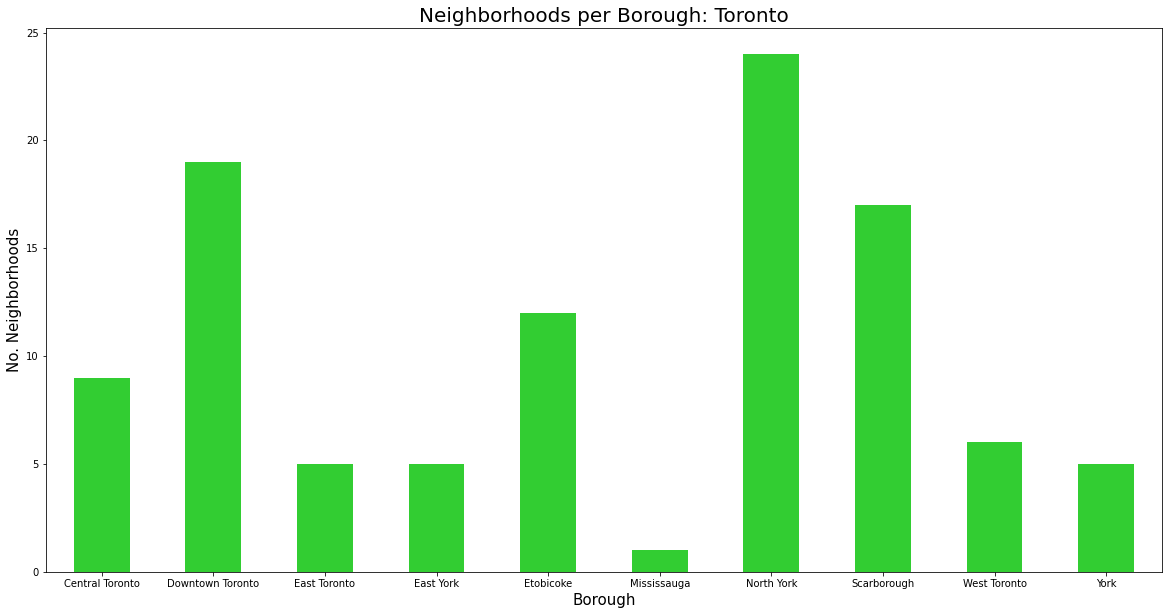

In [9]:
clr = "limegreen"
df_toronto.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(20,10), color=clr)
plt.title('Neighborhoods per Borough: Toronto', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

## Checking for the number of Indonesian restaurants in Toronto

In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indonesian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_toronto.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indonesian_resturants=venues[venues['Category']=='Indonesian Restaurant']   
    print('(',count,'/',len(df_toronto),')','Indonesian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indonesian_resturants)))
    print(row)
    for resturant_detail in indonesian_resturants.values.tolist():
        id, name , category=resturant_detail
        indonesian_rest_toronto = indonesian_rest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indonesian Resturants in Malvern, Rouge, Scarborough:0
['Scarborough', 'Malvern, Rouge', 43.806686299999996, -79.19435340000001]
( 2 / 103 ) Indonesian Resturants in Rouge Hill, Port Union, Highland Creek, Scarborough:0
['Scarborough', 'Rouge Hill, Port Union, Highland Creek', 43.7845351, -79.16049709999999]
( 3 / 103 ) Indonesian Resturants in Guildwood, Morningside, West Hill, Scarborough:0
['Scarborough', 'Guildwood, Morningside, West Hill', 43.7635726, -79.1887115]
( 4 / 103 ) Indonesian Resturants in Woburn, Scarborough:0
['Scarborough', 'Woburn', 43.7709921, -79.21691740000001]
( 5 / 103 ) Indonesian Resturants in Cedarbrae, Scarborough:0
['Scarborough', 'Cedarbrae', 43.773136, -79.23947609999999]
( 6 / 103 ) Indonesian Resturants in Scarborough Village, Scarborough:0
['Scarborough', 'Scarborough Village', 43.7447342, -79.23947609999999]
( 7 / 103 ) Indonesian Resturants in Kennedy Park, Ionview, East Birchmount Park, Scarborough:0
['Scarborough', 'Kennedy Park, Ionvi

In [14]:
indonesian_rest_toronto.to_csv('indonesian_rest_toronto_tocsv1.csv')

In [15]:
indonesian_rest_toronto = pd.read_csv('indonesian_rest_toronto_tocsv1.csv')
indonesian_rest_toronto.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name


## Getting nearby venues for Toronto in all its neighborhoods

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [18]:
toronto_venues.tail(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2117,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,Pizza Pizza,43.741569,-79.584489,Pizza Place
2118,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,Sunny Foodmart,43.741840,-79.590561,Grocery Store
2119,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,McDonald's,43.741757,-79.584230,Fast Food Restaurant
2120,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,Rogers Plus,43.741312,-79.585263,Video Store
2121,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,NORI SUSHI,43.742775,-79.586985,Japanese Restaurant
2122,"Northwest, West Humber - Clairville",43.706748,-79.594054,Economy Rent A Car,43.708471,-79.589943,Rental Car Location
2123,"Northwest, West Humber - Clairville",43.706748,-79.594054,Logistics Distribution,43.707554,-79.589252,Bar
2124,"Northwest, West Humber - Clairville",43.706748,-79.594054,Saand Rexdale,43.705072,-79.598725,Drugstore
2125,"Northwest, West Humber - Clairville",43.706748,-79.594054,PC Garden,43.706539,-79.599359,Garden Center
2126,"Northwest, West Humber - Clairville",43.706748,-79.594054,Vectra Heavy Haulers,43.704891,-79.599410,Truck Stop


In [19]:
tor_venue_rest = toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant', na=False)].reset_index(drop=True)

tor_venue_rest.tail(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
471,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,New Toronto Fish & Chips,43.601849,-79.503281,Restaurant
472,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,McDonald's,43.602464,-79.498859,Fast Food Restaurant
473,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,Maple Leaf House,43.602040,-79.498678,American Restaurant
474,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,Hex-Mex,43.601261,-79.502284,Mexican Restaurant
475,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,McDonald's,43.630002,-79.518198,Fast Food Restaurant
476,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,Carolina's Cuisina,43.648863,-79.549504,Filipino Restaurant
477,Westmount,43.696319,-79.532242,Mayflower Chinese Food,43.692753,-79.531566,Chinese Restaurant
478,Westmount,43.696319,-79.532242,2 Bros Cuisine,43.692499,-79.531698,Middle Eastern Restaurant
479,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,McDonald's,43.741757,-79.584230,Fast Food Restaurant
480,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,NORI SUSHI,43.742775,-79.586985,Japanese Restaurant


## One-hot Encoding

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(tor_venue_rest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = tor_venue_rest['Neighborhood'] 

# move neighborhood column to the first column
cols=list(toronto_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
toronto_onehot=toronto_onehot[['Neighborhood']+cols]

# rename Neighborhood for Neighbourhood so that future merge works
toronto_onehot.rename(columns = {'Neighborhood': 'Neighbourhood'}, inplace = True)

toronto_onehot.tail(10)

,Neighbourhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
471,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
472,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
473,"New Toronto, Mimico South, Humber Bay Shores",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
474,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
475,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
476,"West Deane Park, Princess Gardens, Martin Grov...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
477,Westmount,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
478,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479,"South Steeles, Silverstone, Humbergate, Jamest...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
480,"South Steeles, Silverstone, Humbergate, Jamest...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Checking the mean frequency of visit of the restaurants, grouped by their neighborhoods

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

toronto_grouped

,Neighbourhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Bedford Park, Lawrence Manor East",0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.111111,0.000000,0.111111,0.222222,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.111111,0.000000,0.111111,0.0,0.111111,0.000000,0.000000,0.000000,0.000000
4,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.00,0.000000,0.083333,0.000000,0.083333,0.000000,0.083333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.166667,0.166667,0.000000,0.0,0.083333,0.000000,0.000000,0.083333,0.000000
5,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,Canada Post Gateway Processing Centre,0.33333

## Printing the top 5 venues of each neighbourhood in each city

In [23]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   1.0
1        American Restaurant   0.0
2    New American Restaurant   0.0
3      Korean BBQ Restaurant   0.0
4          Korean Restaurant   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0           Sushi Restaurant  0.33
1  Middle Eastern Restaurant  0.33
2                 Restaurant  0.33
3        American Restaurant  0.00
4        Moroccan Restaurant  0.00


----Bayview Village----
                     venue  freq
0       Chinese Restaurant   0.5
1      Japanese Restaurant   0.5
2      American Restaurant   0.0
3  New American Restaurant   0.0
4        Korean Restaurant   0.0


----Bedford Park, Lawrence Manor East----
                     venue  freq
0       Italian Restaurant  0.22
1  Comfort Food Restaurant  0.11
2          Thai Restaurant  0.11
3         Sushi Restaurant  0.11
4               Restaurant  0.11


----Berczy Park----
                

## Creating a function to sort the venues in descending order

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Creating a pandas dataframe to find the neighbourhood's top 10 venues, for both cities

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Indian Restaurant,Sushi Restaurant,Comfort Food Restaurant,Greek Restaurant,Restaurant,American Restaurant,Thai Restaurant,Seafood Restaurant,German Restaurant
4,Berczy Park,Restaurant,Seafood Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Japanese Restaurant,Eastern European Restaurant,Comfort Food Restaurant,Greek Restaurant,Thai Restaurant
5,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
6,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
7,Canada Post Gateway Processing Centre,American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Hakka Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
8,Cedarbrae,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
9,Central Bay Street,Italian Restaurant,Thai Restaurant,Indian Restaurant,Portuguese Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Middle Eastern Restaurant,French Restaurant


## Running k-Means, assuming k = 5

In [26]:
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0])

In [28]:
toronto_merged = df_toronto

neighborhoods_venues_sorted.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted['Cluster Labels'] = neighborhoods_venues_sorted['Cluster Labels'].astype(int)

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(20)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2.0,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
3,Scarborough,Woburn,43.770992,-79.216917,0.0,Korean BBQ Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
5,Scarborough,Scarborough Village,43.744734,-79.239476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,3.0,American Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
9,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
toronto_merged = toronto_merged.dropna().reset_index()

toronto_merged.tail(10)

,index,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,83,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,0.0,Italian Restaurant,Restaurant,Cuban Restaurant,Eastern European Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
55,84,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,0.0,Italian Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Restaurant,Latin American Restaurant,Falafel Restaurant,Vietnamese Restaurant,Doner Restaurant,Filipino Restaurant
56,85,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
57,86,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,3.0,American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Hakka Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
58,87,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0.0,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
59,88,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,0.0,American Restaurant,Fast Food Restaurant,Restaurant,Mexican Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
60,92,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,2.0,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
61,94,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,4.0,Filipino Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
62,99,Etobicoke,Westmount,43.696319,-79.532242,1.0,Chinese Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
63,101,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.0,Japanese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [30]:
toronto_merged['Cluster Labels']= toronto_merged['Cluster Labels'].astype(int)

toronto_merged

,index,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,3,Scarborough,Woburn,43.770992,-79.216917,0,Korean BBQ Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,4,Scarborough,Cedarbrae,43.773136,-79.239476,0,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
4,8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,3,American Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
5,10,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,0,Indian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Theme Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
6,11,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,1,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
7,12,Scarborough,Agincourt,43.794200,-79.262029,0,Latin American Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
8,13,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,0,Fast Food Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
9,15,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,2,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant


In [31]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


In [32]:
map_clusters_tor = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_tor)
       
map_clusters_tor

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,0,Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,Scarborough,0,Korean BBQ Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,Scarborough,0,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
5,Scarborough,0,Indian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Theme Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
7,Scarborough,0,Latin American Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
8,Scarborough,0,Fast Food Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
11,North York,0,Fast Food Restaurant,Japanese Restaurant,Restaurant,Chinese Restaurant,American Restaurant,Greek Restaurant,Asian Restaurant,Caribbean Restaurant,Cajun / Creole Restaurant,Gluten-free Restaurant
12,North York,0,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
13,North York,0,Ramen Restaurant,Sushi Restaurant,Vietnamese Restaurant,Japanese Restaurant,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Dim Sum Restaurant,French Restaurant,Filipino Restaurant
15,North York,0,Japanese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Caribbean Restaurant,Chinese Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Eastern European Restaurant,German Restaurant


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,1,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
41,Central Toronto,1,Indian Restaurant,Middle Eastern Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
49,West Toronto,1,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
62,Etobicoke,1,Chinese Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
9,Scarborough,2,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
14,North York,2,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
52,York,2,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
60,Etobicoke,2,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Scarborough,3,American Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
10,North York,3,Mediterranean Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
57,Mississauga,3,American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Hakka Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Etobicoke,4,Filipino Restaurant,Vietnamese Restaurant,Doner Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
